# About
### example using of keras Tokenizer combined with sklearn model for checking sentiment of text data (Twitter US Airline Sentiment). Data comes from Kaggle.com (https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment)
### the goal is to predict negative/positive sentiment based on tweet text =>managed to achive ~90% accuracy 

## 1. Imports

In [1]:
from pathlib import Path
import numpy as np 
import pandas as pd

import re
import warnings
import itertools
from datetime import datetime, timedelta

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
pd.options.mode.chained_assignment = None
import random

## 2. Paths

In [2]:
CWD = Path.cwd()
#folder when we store our train and test data
DATA = CWD / "DATA"
DATA.mkdir(parents=True, exist_ok=True)

## 3. Datetime

In [3]:
now = datetime.now()
current_date = now.strftime("%Y-%m-%d")
current_year = now.year
current_month = now.month

## 4. Helper method

In [4]:
import pandas as pd

def check_data(df: pd.DataFrame) -> pd.DataFrame:
    df_output = pd.DataFrame(columns=["column_name", "number_of_empties","number_of_uniques"])
    for col in df.columns:
        df_output = df_output.append({"column_name": col, "number_of_empties" : len(df[df[col].isna()]), "number_of_uniques": len(df[col].unique())} ,ignore_index=True)  
    ##df_output = df_output[df_output['number_of_empties']>0]  
    return df_output

## 5 First look at data
cleaning, feature selection, feature engineering

In [5]:
#workspace dataframe 
df_ws = pd.read_csv(DATA/"Tweets.csv", index_col=0)
df_ws.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14640 entries, 570306133677760513 to 569587140490866689
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airline_sentiment             14640 non-null  object 
 1   airline_sentiment_confidence  14640 non-null  float64
 2   negativereason                9178 non-null   object 
 3   negativereason_confidence     10522 non-null  float64
 4   airline                       14640 non-null  object 
 5   airline_sentiment_gold        40 non-null     object 
 6   name                          14640 non-null  object 
 7   negativereason_gold           32 non-null     object 
 8   retweet_count                 14640 non-null  int64  
 9   text                          14640 non-null  object 
 10  tweet_coord                   1019 non-null   object 
 11  tweet_created                 14640 non-null  object 
 12  tweet_location                

In [6]:
check_data(df_ws)

C:\Users\Piotr\AppData\Local\Temp/ipykernel_29108/3140603459.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append({"column_name": col, "number_of_empties" : len(df[df[col].isna()]), "number_of_uniques": len(df[col].unique())} ,ignore_index=True)
C:\Users\Piotr\AppData\Local\Temp/ipykernel_29108/3140603459.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append({"column_name": col, "number_of_empties" : len(df[df[col].isna()]), "number_of_uniques": len(df[col].unique())} ,ignore_index=True)
C:\Users\Piotr\AppData\Local\Temp/ipykernel_29108/3140603459.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append({"column_name": col, "number_of_empties" : 

,column_name,number_of_empties,number_of_uniques
0,airline_sentiment,0,3
1,airline_sentiment_confidence,0,1023
2,negativereason,5462,11
3,negativereason_confidence,4118,1411
4,airline,0,6
5,airline_sentiment_gold,14600,4
6,name,0,7701
7,negativereason_gold,14608,14
8,retweet_count,0,18
9,text,0,14427


### 5.1 basic Feature selection
looking at above checks I can clearly drop a few columns that are totaly "informationless" for our further model

In [7]:
df_ws_step1 = df_ws.drop(['user_timezone','tweet_coord','airline_sentiment_gold','name','negativereason_gold',
                         'tweet_created','tweet_location'], axis=1)

### 5.2 our target (airline_sentiment)

<AxesSubplot: xlabel='airline_sentiment', ylabel='count'>

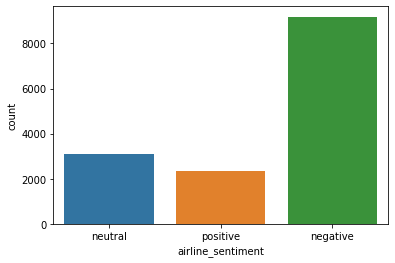

In [8]:
sns.countplot(x=df_ws_step1['airline_sentiment'])

### 5.3 deleting neutral sentiment tweets
we need bipolar sentiment data to catch positive/ negative sentiment based on tweet in our model

In [9]:
df_ws_step2 = df_ws_step1[df_ws_step1['airline_sentiment'] != 'neutral']
df_ws_step2.airline_sentiment.unique()

array(['positive', 'negative'], dtype=object)

In [10]:
df_ws_step2.groupby(by=['airline_sentiment']).count()['text']

airline_sentiment
negative    9178
positive    2363
Name: text, dtype: int64

<AxesSubplot: xlabel='airline_sentiment', ylabel='count'>

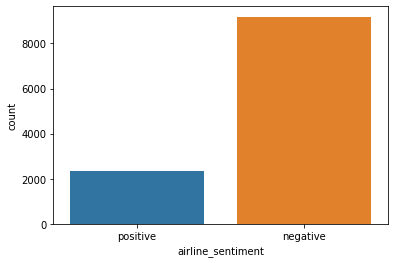

In [11]:
sns.countplot(x=df_ws_step2['airline_sentiment'])

as there is a significant disproportion in "negative" / "positive" tweets I will delete some negative tweets

In [12]:
#starting with those negatives that are not sure in 100%
conditions = (df_ws_step2['airline_sentiment']=="negative") & (df_ws_step2['airline_sentiment_confidence']<1)
condtition_idx = df_ws_step2[conditions].index
print(f"Number of tweets that are not 100% correctly marked 'negative': {len(condtition_idx)}")

Number of tweets that are not 100% correctly marked 'negative': 1796


In [13]:
df_ws_step3 = df_ws_step2.drop(condtition_idx)

### 5.4 deleting duplicated rows 

In [14]:
#during process of data cleaning I've also noticed some duplicated rows, here's an example:
df_ws_step3[df_ws_step3.index.duplicated(keep=False)].loc[570308309682675712]

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,retweet_count,text
tweet_id,,,,,,,
570308309682675712,negative,1.0,Customer Service Issue,1.0,American,0,@AmericanAir why would I even consider continu...
570308309682675712,negative,1.0,Customer Service Issue,1.0,American,0,@AmericanAir why would I even consider continu...


In [15]:
df_ws_step4 = df_ws_step3[~df_ws_step3.index.duplicated(keep='first')]
print(f"Deleted: {len(df_ws_step3) - len(df_ws_step4)} duplicated rows")

Deleted: 87 duplicated rows


### 5.5 Balancing classes proportions

In [16]:
print(f"current negative tweets: {df_ws_step4[df_ws_step4['airline_sentiment']=='negative']['airline_sentiment'].count()}")
print(f"current positive tweets: {df_ws_step4[df_ws_step4['airline_sentiment']=='positive']['airline_sentiment'].count()}")

current negative tweets: 7296
current positive tweets: 2338


In [17]:
NEGATIVES_TO_DELETE = 4900
# deleting first 4900 'negative' rows at random
df_ws_step5 = df_ws_step4.drop( df_ws_step4[df_ws_step4.airline_sentiment == "negative"].iloc[:NEGATIVES_TO_DELETE].index  )

In [18]:
print(f"current negative tweets: {df_ws_step5[df_ws_step5['airline_sentiment']=='negative']['airline_sentiment'].count()}")
print(f"current positive tweets: {df_ws_step5[df_ws_step5['airline_sentiment']=='positive']['airline_sentiment'].count()}")

current negative tweets: 2396
current positive tweets: 2338


<AxesSubplot: xlabel='airline_sentiment', ylabel='count'>

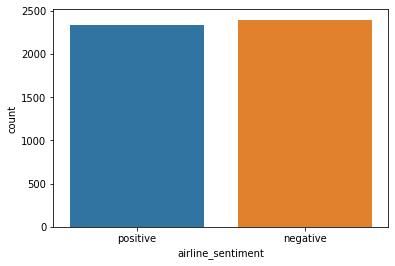

In [19]:
sns.countplot(x=df_ws_step5['airline_sentiment'])

### 5.6 new_column --> if_retweeted - based on number of tweets 

In [20]:
conditions = [(df_ws_step5['retweet_count'] > 0),
             (df_ws_step5['retweet_count'] == 0)]
values = [1,0]
df_ws_step5['if_retweeted'] = np.select(conditions,values)

checking if it might give us some information

In [21]:
if_retweeted_check_groups = df_ws_step5.groupby(by=['if_retweeted','airline_sentiment']).agg(tweet_count = ('airline_sentiment','count')).unstack()
if_retweeted_check_groups

tweet_count         
airline_sentiment    negative positive
if_retweeted                          
0                        2311     2262
1                          85       76

<AxesSubplot: xlabel='if_retweeted'>

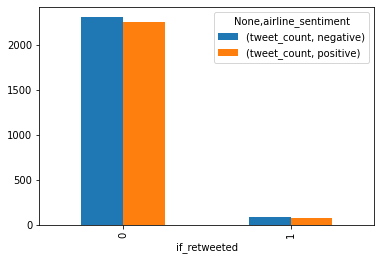

In [22]:
if_retweeted_check_groups.plot(kind='bar')

This clearly show that the number of retweets is worthless in our case

### 5.7 checking 'airline' field

<AxesSubplot: xlabel='airline', ylabel='count'>

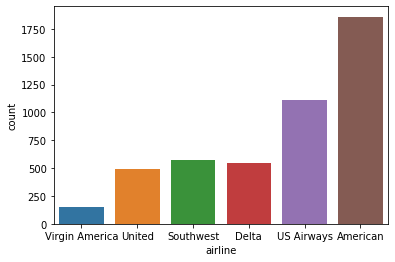

In [23]:
sns.countplot(x=df_ws_step5['airline'])

checking if some airline have worse opinions than other

In [24]:
airline_check_groups = df_ws_step5.groupby(by=['airline','airline_sentiment']).agg(tweet_count = ('airline','count')).unstack(fill_value=0)
airline_check_groups

tweet_count         
airline_sentiment    negative positive
airline                               
American                 1549      311
Delta                       1      544
Southwest                   0      570
US Airways                846      269
United                      0      492
Virgin America              0      152

<AxesSubplot: xlabel='airline'>

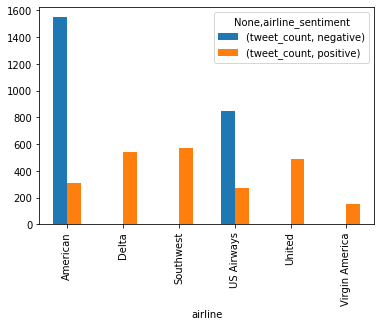

In [25]:
airline_check_groups.plot(kind='bar')

Clearly "American" and "US Airways" have much more negative feedback on twitter than other airlines

In [26]:
#final clearance of not needed columns
df_ws_step6 = df_ws_step5.drop(['airline_sentiment_confidence','negativereason','negativereason_confidence','retweet_count','if_retweeted'], axis=1)

## 6. "text" column 
this is the most important field of all for sure => text of the tweet

### 6.1 applying lowercase to all text

In [27]:
df_ws_step6['text'] = df_ws_step6['text'].apply(lambda x: x.lower())

#7 Building a Model

## Using external tokenizer

In [28]:
df_ws_step7 = df_ws_step6[["text","airline_sentiment"]]
df_ws_step7['text'] = df_ws_step7['text'].map(lambda x: x.lstrip('@VirginAmerica@UnitedAir@Southwestairline@DeltaAir@USAirways@American').rstrip('@'))
df_ws_step7['text'] = df_ws_step7['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x))) # To keep numbers and strings only

In [29]:
max_fatures = 4000
tokenizer = Tokenizer(num_words = max_fatures, split=' ')
tokenizer.fit_on_texts(df_ws_step7['text'].values)
X = tokenizer.texts_to_sequences(df_ws_step7['text'].values)
X = pad_sequences(X)
Y = df_ws_step7['airline_sentiment']
k = Y.apply(lambda x: x.replace("positive","1")).apply(lambda x: x.replace("negative","0")).astype(int)

## 7 train, test split

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(X, k, 
                                                    test_size=0.3, 
                                                    shuffle = True,
                                                    stratify = k)

## 8 building and training model

In [70]:
embed_dim = 128
lstm_out = 196
model_2 = tf.keras.models.Sequential()
model_2.add(tf.keras.layers.Embedding(max_fatures, 128, input_length=X_train.shape[1]))
model_2.add(tf.keras.layers.SpatialDropout1D(0.5))
model_2.add(tf.keras.layers.LSTM(196, dropout = 0.3, recurrent_dropout = 0.3 ))
model_2.add(tf.keras.layers.Dropout(0.2))
model_2.add(tf.keras.layers.Dense(100, activation = tf.nn.relu))
model_2.add(tf.keras.layers.Dropout(0.4))
model_2.add(tf.keras.layers.Dense(2, activation = tf.nn.softmax))

In [71]:
model_2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [72]:
Model_2 = model_2.fit(X_train,
                      Y_train,
                      epochs=10,
                      batch_size=32,
                      validation_split = 0.3,
                      verbose = 2)

Epoch 1/2


C:\Users\Piotr\anaconda3\lib\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


73/73 - 5s - loss: 0.5430 - accuracy: 0.7318 - val_loss: 0.3698 - val_accuracy: 0.8330 - 5s/epoch - 74ms/step
Epoch 2/2
73/73 - 3s - loss: 0.2602 - accuracy: 0.8995 - val_loss: 0.2426 - val_accuracy: 0.9074 - 3s/epoch - 43ms/step


## 9 evaluating and predicting using model

In [73]:
score_2 = model_2.evaluate(X_test, Y_test, verbose=False)
print(f"loss = {score_2[0]}")
print(f"accuracy = {score_2[1]}")

loss = 0.23457291722297668
accuracy = 0.9148486852645874


In [74]:
def predict_sentence_sentiment(sentence:str, model: tf.keras.models.Sequential):
    """
    predicting sentiment (negative/positive) based on keras model and sentence(str)
    """
    sample = tokenizer.texts_to_sequences([sentence]) #needs sentence as a list
    sample = pad_sequences(sample, maxlen=31, dtype='int32', value=0)
    #print(sample)
    sentiment_prob = model.predict(sample, batch_size=1, verbose=2)[0]
    print(sentiment_prob)
    if (np.argmax(sentiment_prob)==0):
        return "negative"
    elif (np.argmax(sentiment_prob)==1):
        return "positive"

# 10 Tests

In [75]:
predict_sentence_sentiment("There was a massive delay, and the crew was not nice", model_2)

1/1 - 0s - 174ms/epoch - 174ms/step
[0.18139032 0.8186097 ]


'positive'

In [76]:
## chosing random text from data 
random_sentence = random.choice(df_ws_step7['text'].to_list())

In [77]:
known_sentiment = df_ws_step7['airline_sentiment'][df_ws_step7['text']==random_sentence].to_list()[0]

In [78]:
print(f"RANDOM TEXT: {random_sentence}")
print(f"KNOWN SENTIMENT: {known_sentiment}")

RANDOM TEXT:  loving the boarding to go to chicago keepitmovin
KNOWN SENTIMENT: positive


In [79]:
#check sentiment

In [80]:
model_prediction = predict_sentence_sentiment(random_sentence,model_2)
model_prediction

1/1 - 0s - 32ms/epoch - 32ms/step
[0.10775878 0.8922412 ]


'positive'

In [81]:
# compare
if model_prediction==known_sentiment:
    print(f"correctly predicted sentiment of text: {random_sentence} \nAs:  '{model_prediction}'")
else:
    print(f"incorrect prediction of text: {random_sentence}\nPredicted: {model_prediction}\nCorrect: {known_sentiment}")

correctly predicted sentiment of text:  loving the boarding to go to chicago keepitmovin 
As:  'positive'


# 11 confusion matrix

In [82]:
y_pred = model_2.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 

45/45 [==============================] - 1s 8ms/step


In [83]:
confusion_matrix(Y_test, y_pred_classes) 

array([[648,  71],
       [ 50, 652]], dtype=int64)

In [84]:
model_2

# Notes